# Climate skill at 1&deg;: time-mean RMSE

In [1]:
from collections import namedtuple
import re
from string import ascii_lowercase

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import wandb_to_beaker_experiment, wandb_to_beaker_result, get_scalar_metrics
from constants import INFERENCE_COMPARISON_1DEG, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [2]:
mpl.rc('font', size=8)

In [3]:
api = wandb.Api()
WandbRun = namedtuple('WandbRun', ['project', 'id'])
EvalVar = namedtuple('EvalVar', ['name', 'conversion_factor', 'long_name', 'units', 'scale'])
EvalMetric = namedtuple('EvalMetric', ['name', 'long_name'])

In [4]:
TIME_MEAN_EVAL_VARS = [
    EvalVar('TMP2m', None, '2-meter temperature', 'K', 0.35),
    EvalVar('PRATEsfc', SECONDS_PER_DAY, 'surface precipitation rate', 'mm/day', 0.6),
    EvalVar('total_water_path', None, 'total water path', 'mm', 1.0),
    EvalVar('h500', None, '500hPa height', 'm', 10)
]
TIME_MEAN_METRIC = EvalMetric("inference/time_mean/rmse", "RMSE of time-mean")

In [5]:
all_metrics = [(eval_var, TIME_MEAN_METRIC) for eval_var in TIME_MEAN_EVAL_VARS]
all_metric_names = [
    '/'.join([metric.name, eval_var.name])
    for eval_var, metric in all_metrics
]
print(f"{all_metric_names=}")

all_metric_names=['inference/time_mean/rmse/TMP2m', 'inference/time_mean/rmse/PRATEsfc', 'inference/time_mean/rmse/total_water_path', 'inference/time_mean/rmse/h500']


In [6]:
metrics = {}
for run_group_name, run_group in INFERENCE_COMPARISON_1DEG["10yr"].items():
    if isinstance(run_group, dict):
        for ic_name, run_id in run_group.items():
            if '-' in ic_name:
                ic_name = ic_name.split('-')[1]
            full_key = '/'.join([run_group_name, ic_name])
            print(f"Getting metrics for {full_key=}.")
            run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
            metrics[full_key] = get_scalar_metrics(run, all_metric_names)
    else:
        full_key = '/'.join([run_group_name])
        print(f"Getting metrics for {full_key=}.")
        run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_group}")
        metrics[full_key] = get_scalar_metrics(run, all_metric_names)

Getting metrics for full_key='ACE2-ERA5/IC0'.
Getting metrics for full_key='ACE2-ERA5/IC1'.
Getting metrics for full_key='ACE2-ERA5/IC2'.
Getting metrics for full_key='ACE2-AMIP/IC0'.
Getting metrics for full_key='ACE2-AMIP/IC1'.
Getting metrics for full_key='ACE2-AMIP/IC2'.
Getting metrics for full_key='AMIP-reference'.
Getting metrics for full_key='AMIP-vs.-ERA5/IC0'.
Getting metrics for full_key='AMIP-vs.-ERA5/IC1'.


In [7]:
metrics

{'ACE2-ERA5/IC0': {'inference/time_mean/rmse/TMP2m': 0.22029906511306763,
  'inference/time_mean/rmse/PRATEsfc': 4.03525245928904e-06,
  'inference/time_mean/rmse/total_water_path': 0.6553439497947693,
  'inference/time_mean/rmse/h500': 8.015103340148926},
 'ACE2-ERA5/IC1': {'inference/time_mean/rmse/TMP2m': 0.21808268129825592,
  'inference/time_mean/rmse/PRATEsfc': 4.1544221858202945e-06,
  'inference/time_mean/rmse/total_water_path': 0.7010932564735413,
  'inference/time_mean/rmse/h500': 6.614434719085693},
 'ACE2-ERA5/IC2': {'inference/time_mean/rmse/TMP2m': 0.2051631361246109,
  'inference/time_mean/rmse/PRATEsfc': 4.122086465940811e-06,
  'inference/time_mean/rmse/total_water_path': 0.6562535166740417,
  'inference/time_mean/rmse/h500': 5.405556678771973},
 'ACE2-AMIP/IC0': {'inference/time_mean/rmse/TMP2m': 0.21627220511436462,
  'inference/time_mean/rmse/PRATEsfc': 3.4892293570010224e-06,
  'inference/time_mean/rmse/total_water_path': 0.4530387222766876,
  'inference/time_mean/

In [8]:
ic_key = '/IC[0-9]*$'
duration_key = '^[0-9]*yr/'
das = []
for run_name, run_metrics in metrics.items():
    run_coords = {}
    ic_match = re.search(ic_key, run_name)
    if ic_match:
        trimmed_run_name = run_name[0:ic_match.span()[0]]
        run_coords['IC'] = [ic_match.group().strip('/')]
    else:
        trimmed_run_name = run_name
    duration_match = re.search(duration_key, trimmed_run_name)
    if duration_match:
        trimmed_run_name = trimmed_run_name[duration_match.span()[1]:]
        run_coords['duration'] = [duration_match.group().strip('/')]
    else:
        trimmed_run_name = trimmed_run_name
    metric_names, metric_values = zip(*run_metrics.items())
    run_da = xr.DataArray(list(metric_values), dims='metric', coords={'metric': list(metric_names)}, name=trimmed_run_name)
    das.append(run_da.expand_dims(run_coords))
all_metrics_ds = xr.merge(das) 

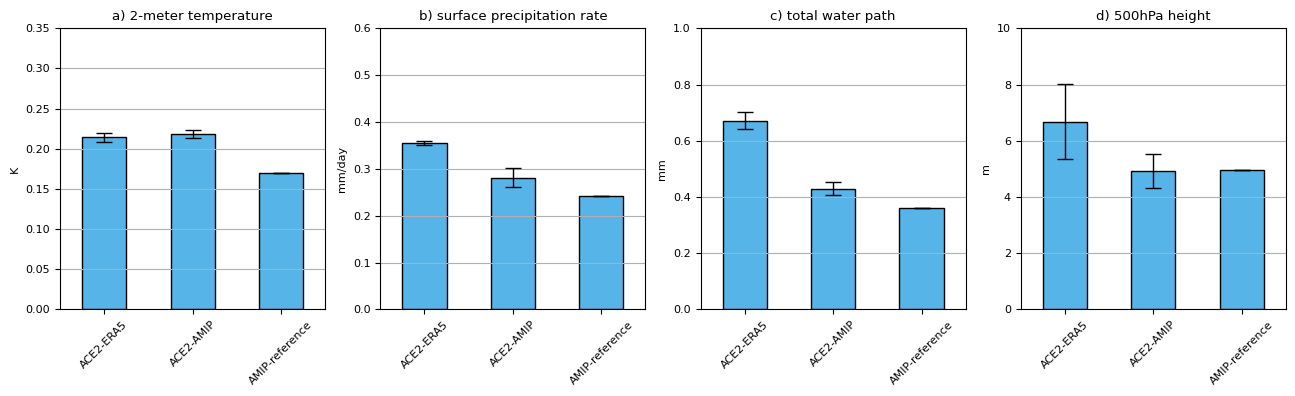

In [9]:
nrows, ncols = 1, len(TIME_MEAN_EVAL_VARS)
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=False)

if len(axes.shape) == 1:
    # if only plotting one variable
    axes = axes[:, None]
    
for i, variable in enumerate(TIME_MEAN_EVAL_VARS):
    full_metric_name = '/'.join([TIME_MEAN_METRIC.name, variable.name])
    ax = axes[i, 0]
    metric_ds = all_metrics_ds.sel(metric=full_metric_name).drop_vars(['AMIP-vs.-ERA5'])
    if variable.conversion_factor is not None:
        metric_ds = metric_ds * variable.conversion_factor
    mean = metric_ds.mean('IC')
    yupper = (metric_ds.max('IC') - mean)
    ylower = (metric_ds.min('IC') - mean)
    both = np.vstack([yupper.to_array().to_numpy(), ylower.to_array().to_numpy()])
    mean.to_array(dim='run_group', name=full_metric_name).to_dataframe().plot.bar(yerr=both, ax=ax, error_kw=dict(capsize=6, linewidth=1, color='k'), linewidth=1, edgecolor='k', legend=False)
    ax.set_xlabel(None)
    ax.set_ylabel(f"{variable.units}")
    ax.grid(axis='y')
    ax.set_ylim([0, variable.scale])
    ax.set_title(f"{ascii_lowercase[i]}) {variable.long_name}")
for ax in axes.flatten():
    ax.set_xticklabels([varname.replace('_', ' ') for varname in metric_ds.data_vars], rotation=45)
fig.set_size_inches([13, 4])
fig.tight_layout()
fig.savefig('time_mean_rmse_1deg.png', bbox_inches='tight', facecolor='w')